In [1]:
import sys
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import copy
sys.path.insert(0, '/home/ryan/projects/CHARM-KASTr/py/')
from extraction import *

Loading in the files (mainly bias and flats)

In [2]:
import glob

import astropy.io.fits as fits

biaspath = "/home/ryan/projects/KASTr_data/raw/1April2019/red/bias/"

flatpath = "/home/ryan/projects/KASTr_data/raw/1April2019/red/flat/"

sciencepath = "/home/ryan/projects/KASTr_data/raw/1April2019/red/science/"

arcpath = "/home/ryan/projects/KASTr_data/raw/1April2019/red/arc/"

darkpath = "/home/ryan/projects/KASTr_data/raw/1April2019/red/dark/"

BIAS = []

FLAT = []

SCIENCE = []

ARC = []

for filename in glob.glob(biaspath + '*.fits'):
    BIAS.append(fits.open(filename))

for filename in glob.glob(flatpath + '*.fits'):
    FLAT.append(fits.open(filename))

for filename in glob.glob(sciencepath + '*.fits'):
    SCIENCE.append(fits.open(filename))

for filename in glob.glob(arcpath + '*.fits'):
    ARC.append(fits.open(filename))

Making the median bias frame and the median flat frame.
Subtracting the bias from the flat, creating the mask, and normalizing the flat.

In [3]:
median_biasframe = cube_median(BIAS)

median_flatframe = cube_median(FLAT)

bias_subtracted_flat = bias_subtract(median_flatframe, median_biasframe)

image_mask = create_mask(bias_subtracted_flat, median_biasframe)

norm_flat = normalize_flat(bias_subtracted_flat, image_mask)

Standard Reduction Script

First stage produces the image slices and the spatial profile.
Analyze the spatial profile to identify what threshold to choose for
background subtraction, then run the second stage. The second stage is
common between standards and science targets.

In [4]:
def reduce_standard_first_stage(image_path, bias_frame, normalized_flat, mask, px_thresh):
    
    image_file = fits.open(image_path)
    
    image_data = copy.deepcopy(image_file[0].data)
    
    bias_subtracted_image = bias_subtract(image_data, bias_frame)
    
    image_variance = variance_image(bias_subtracted_image)
    
    normalized_image = flat_normalize_image(bias_subtracted_image, normalized_flat, mask)
    
    normalized_variance = flat_normalize_image(image_variance, normalized_flat, mask)
    
    masked_image = mask_image(normalized_image, mask)
    
    masked_variance = mask_image(normalized_variance, mask)
    
    poly_slit_model = slit_fit_model(masked_image)
    
    poly_slit_trace = np.poly1d(poly_slit_model)
    
    image_slices = gen_cent_slc(masked_image, poly_slit_trace, px_thresh)
    
    variance_slices = gen_cent_slc(masked_variance, poly_slit_trace, px_thresh)
    
    spatial_profile = create_norm_spatial_profile(image_slices)
    
    return image_slices, variance_slices, poly_slit_model, poly_slit_trace, spatial_profile
    

In [5]:
def reduce_second_stage(image_slices, variance_slices, spatial_profile, bkg_percent_thresh):
    
    bsubtracted_image_slices, background_spec = background_subtract(image_slices, spatial_profile, bkg_percent_thresh)
    
    bsubtracted_variance_slices, vbackground_spec = background_subtract(variance_slices, spatial_profile, bkg_percent_thresh)
    
    extraction_weight = weight_function(bsubtracted_image_slices)
    
    spect = extract_spectrum(bsubtracted_image_slices, extraction_weight)
    
    variance = extract_variance(bsubtracted_variance_slices, extraction_weight)
    
    return spect, variance, background_spec

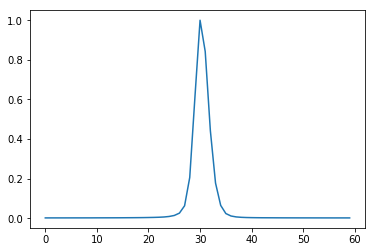

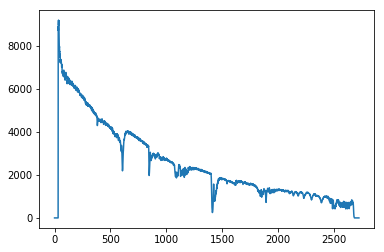

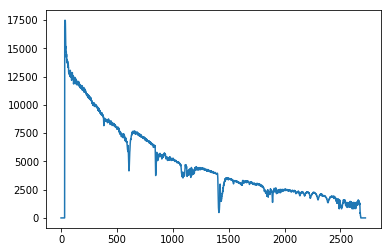

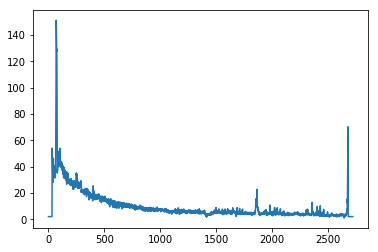

In [6]:
stdpath = '/home/ryan/projects/KASTr_data/raw/1April2019/red/telluric/r1081.fits'

std_slcs, std_varslcs, stdpmod, stdpfit, std_prof = reduce_standard_first_stage(stdpath, median_biasframe, norm_flat, image_mask, 30)

plt.plot(std_prof)
plt.show()

stdspec, stdvar, std_bspec = reduce_second_stage(std_slcs, std_varslcs, std_prof, 0.1)

plt.plot(stdspec)
plt.show()

plt.plot(stdvar)
plt.show()

plt.plot(std_bspec)
plt.show()

Science Reduction Script

In [7]:
def reduce_science(image_path, bias_frame, normalized_flat, mask, px_thresh, poly_slit_trace, poly_slit_model, bkg_percent_thresh):
    
    image_file = fits.open(image_path)
    
    image_data = copy.deepcopy(image_file[0].data)
    
    bias_subtracted_image = bias_subtract(image_data, bias_frame)
    
    image_variance = variance_image(bias_subtracted_image)
    
    normalized_image = flat_normalize_image(bias_subtracted_image, normalized_flat, mask)
    
    normalized_variance = flat_normalize_image(image_variance, normalized_flat, mask)
    
    masked_image = mask_image(normalized_image, mask)
    
    masked_variance = mask_image(normalized_variance, mask)
    
    image_slices = gen_cent_slc(masked_image, poly_slit_trace, px_thresh)
    
    poly_shift = slit_fit_shift(image_slices, poly_slit_model, px_thresh)
    
    shifted_poly = np.poly1d(poly_shift)
    
    centered_slices = gen_cent_slc(masked_image, shifted_poly, px_thresh)
    
    variance_slices = gen_cent_slc(masked_variance, shifted_poly, px_thresh)
    
    spatial_profile = create_norm_spatial_profile(centered_slices)
    
    bsubtracted_image_slices, background_spec = background_subtract(image_slices, spatial_profile, bkg_percent_thresh)
    
    bsubtracted_variance_slices, vbackground_spec = background_subtract(variance_slices, spatial_profile, bkg_percent_thresh)
    
    extraction_weight = weight_function(bsubtracted_image_slices)
    
    spect = extract_spectrum(bsubtracted_image_slices, extraction_weight)
    
    variance = extract_variance(bsubtracted_variance_slices, extraction_weight)
    
    return spect, variance, image_slices, spatial_profile, background_spec

In [7]:
def reduce_science_first_stage(image_path, bias_frame, normalized_flat, mask, px_thresh, poly_slit_trace, poly_slit_model):
    
    image_file = fits.open(image_path)
    
    image_data = copy.deepcopy(image_file[0].data)
    
    bias_subtracted_image = bias_subtract(image_data, bias_frame)
    
    image_variance = variance_image(bias_subtracted_image)
    
    normalized_image = flat_normalize_image(bias_subtracted_image, normalized_flat, mask)
    
    normalized_variance = flat_normalize_image(image_variance, normalized_flat, mask)
    
    masked_image = mask_image(normalized_image, mask)
    
    masked_variance = mask_image(normalized_variance, mask)
    
    image_slices = gen_cent_slc(masked_image, poly_slit_trace, px_thresh)
    
    poly_shift = slit_fit_shift(image_slices, poly_slit_model, px_thresh)
    
    shifted_poly = np.poly1d(poly_shift)
    
    centered_slices = gen_cent_slc(masked_image, shifted_poly, px_thresh)
    
    variance_slices = gen_cent_slc(masked_variance, shifted_poly, px_thresh)
    
    spatial_profile = create_norm_spatial_profile(centered_slices)
    
    return centered_slices, variance_slices, spatial_profile

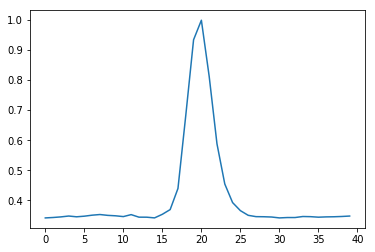

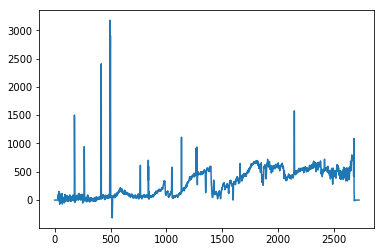

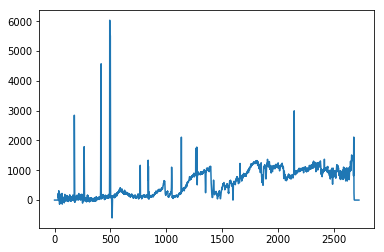

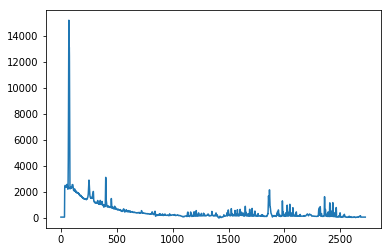

In [10]:
scipath = '/home/ryan/projects/KASTr_data/raw/1April2019/red/science/r1078.fits'

sci_slcs, scivar_slcs, sci_prof = reduce_science_first_stage(scipath, median_biasframe, norm_flat, image_mask, 20, stdpfit, stdpmod)

plt.plot(sci_prof)
plt.show()

scispect, scivar, sci_bkg = reduce_second_stage(sci_slcs, scivar_slcs, sci_prof, 0.4)

plt.plot(scispect)
plt.show()

plt.plot(scivar)
plt.show()

plt.plot(sci_bkg)
plt.show()

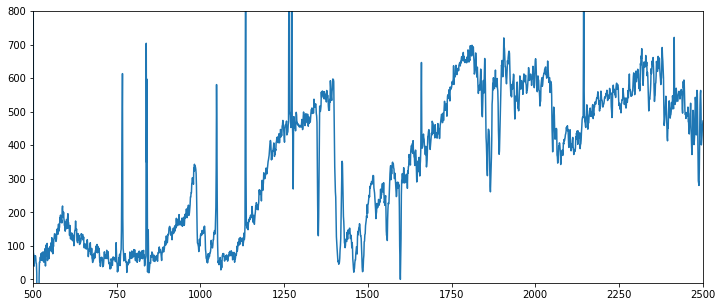

In [11]:
plt.figure(figsize=[12,5])
plt.plot(scispect)
plt.xlim([500,2500])
plt.ylim([-10,800])
plt.show()

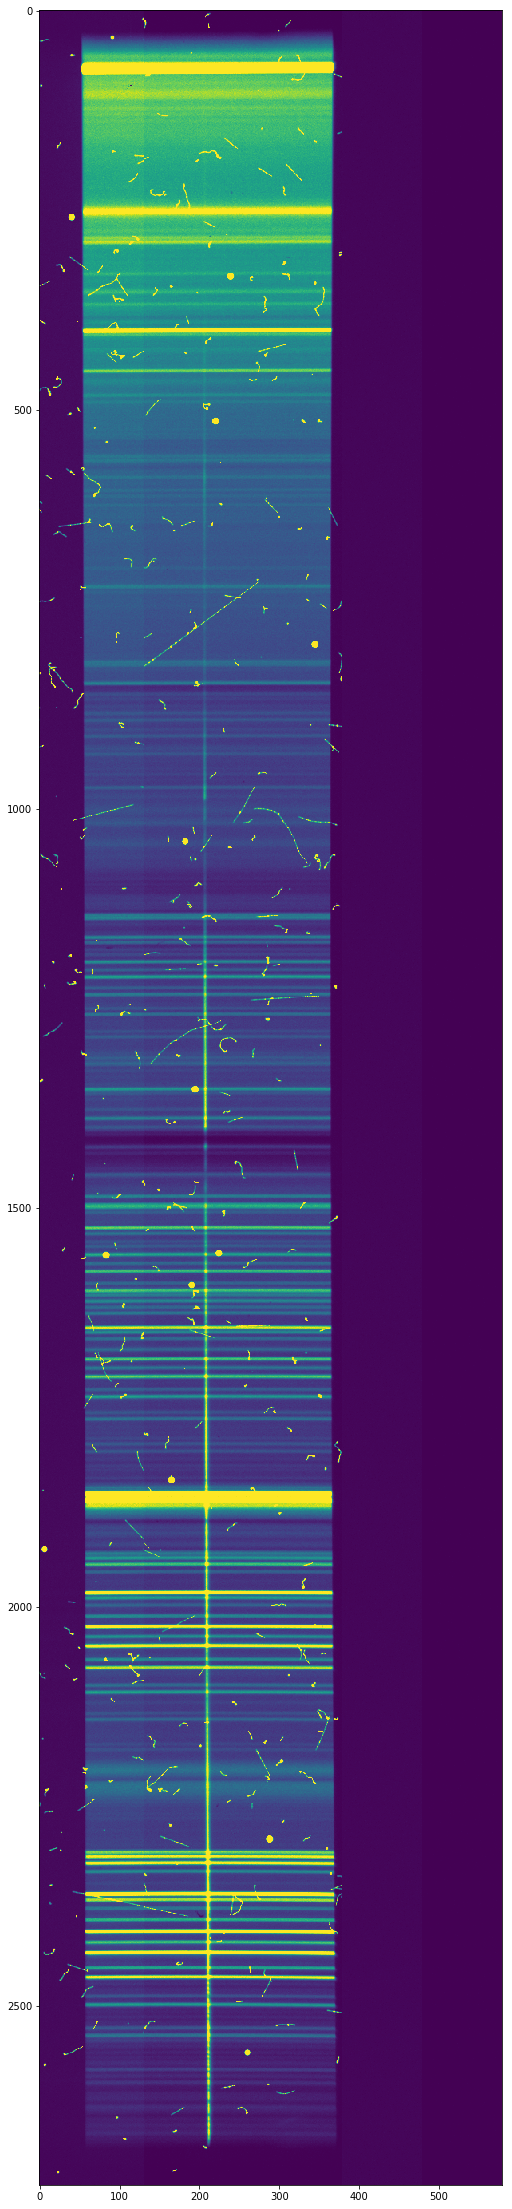

In [20]:
plt.figure(figsize=[10,40])
plt.imshow(fits.open(scipath)[0].data,vmin=1000,vmax=2000)

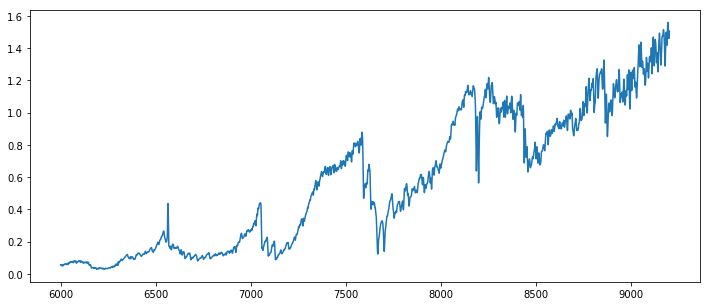

In [31]:
M7standard = np.loadtxt('/home/ryan/projects/KASTr_data/DStandards/stds/M7_all.txt')
plt.figure(figsize=[12,5])
plt.plot(M7standard[:, 0], M7standard[:, 1])

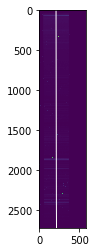

In [11]:
sci_im = copy.deepcopy(fits.open(scipath)[0].data)
xrange = range(len(sci_im[:,0]))
fig, ax = plt.subplots()
ax.imshow(sci_im)
ax.plot(stdpfit(xrange), xrange, color = 'w', linewidth=1)

In [9]:
#only works for 4th order, will tweak later
def slit_fit_shift(cent_slices, slit_fit_model, px_thresh):
    signal_center = np.argmax(np.median(cent_slices, axis=0))
    
    offset = signal_center - px_thresh
    
    shifted_model = copy.deepcopy(slit_fit_model)
    
    shifted_model[4] = shifted_model[4] + offset
    
    return shifted_model

In [4]:
def create_norm_spatial_profile(cent_slcs):
    prof_slcs = copy.deepcopy(cent_slcs)
    for i in range(len(prof_slcs)):
        prof_slcs[i] = prof_slcs[i] / np.amax(prof_slcs[i])
     
    prof = np.median(prof_slcs, axis=0)
    return prof

In [5]:
def background_subtract(c_slc, sp_prof, percent_threshold):
        
    cent_slc = copy.deepcopy(c_slc)
    
    #empty lists to hold the background slices and their indices
    background_slices = []
    '''
       deciding which pixels are background
       background pixels are areas where the spatial
       profile is less than the given threshold
    '''
    for i in range(len(cent_slc)):
        
        #setting up empty lists to hold the background pixels
        background_px = []
        
        
        #if the pixel value in the slice is less than the threshold, it's background
        for j in range(len(cent_slc[i])):
            if (sp_prof[j] < percent_threshold):
                background_px.append(cent_slc[i][j])
        #appending the pixels and indices from this slice to the list for all slices
        
        #if the list isn't empty, append it, otherwise append the orignal slice
        #since it is probably all background in that case
        if background_px != []:
            background_slices.append(background_px)
        else:
            background_slices.append(cent_slc[i])
    
    #empty list to hold the background value
    background_vals = []
    
    #for each slice, find the median and store it
    for i in range(len(background_slices)):
        background_vals.append(np.median(background_slices[i]))
        
    #the signal is the difference between the centered slices and the background
    signal_slc = copy.deepcopy(cent_slc)
        
    for i in range(len(signal_slc)):
        signal_slc[i] = signal_slc[i] - background_vals[i]
    
    return signal_slc, background_vals

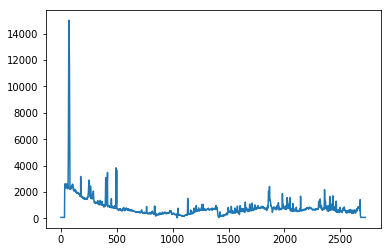

In [14]:
plt.plot(scispect)

In [5]:
stdpath = '/home/ryan/projects/KASTr_data/raw/1April2019/red/telluric/r1081.fits'

stdspec, stdvar, stdpmod, stdpfit, stdprof, stdslcs, b_spec = reduce_standard(stdpath, median_biasframe, norm_flat, image_mask, 30, 0.1)

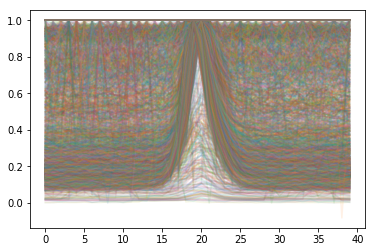

In [16]:
import pandas as pd

norm_sci_slcs = copy.deepcopy(scislcs)

for i in range(len(norm_sci_slcs)):
    norm_sci_slcs[i] = norm_sci_slcs[i] / np.amax(norm_sci_slcs[i])
    
    plt.plot(norm_sci_slcs[i], alpha=0.1)
    
wow = pd.DataFrame(norm_sci_slcs)

wow.to_csv('output.csv', index=False, header=False)


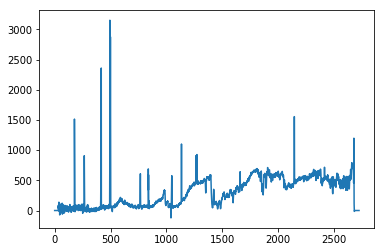

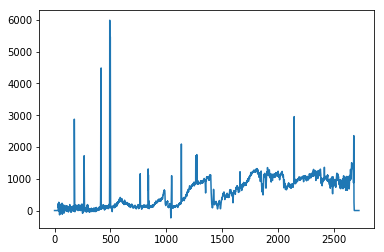

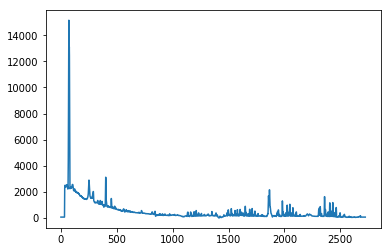

In [9]:
plt.plot(scispect)
plt.show()
plt.plot(scivar)
plt.show()
plt.plot(sci_bkg)
plt.show()

In [8]:
scipath = '/home/ryan/projects/KASTr_data/raw/1April2019/red/science/r1078.fits'
scispect, scivar, scislcs, sciprof, sci_bkg = reduce_science(scipath, median_biasframe, norm_flat, image_mask, 30, stdpfit, stdpmod, 0.4)

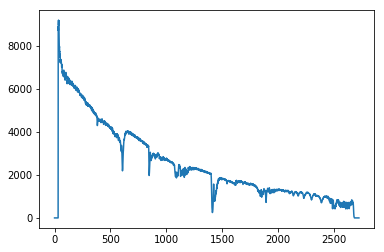

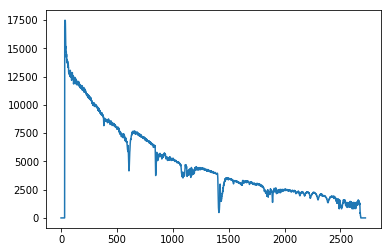

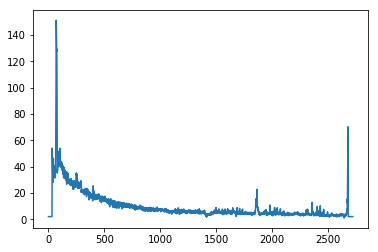

In [6]:
plt.plot(stdspec)
plt.show()
plt.plot(stdvar)
plt.show()
plt.plot(b_spec)
plt.show()

In [4]:
def reduce_standard(image_path, bias_frame, normalized_flat, mask, px_thresh, bkg_percent_thresh):
    
    image_file = fits.open(image_path)
    
    image_data = copy.deepcopy(image_file[0].data)
    
    bias_subtracted_image = bias_subtract(image_data, bias_frame)
    
    image_variance = variance_image(bias_subtracted_image)
    
    normalized_image = flat_normalize_image(bias_subtracted_image, normalized_flat, mask)
    
    normalized_variance = flat_normalize_image(image_variance, normalized_flat, mask)
    
    masked_image = mask_image(normalized_image, mask)
    
    masked_variance = mask_image(normalized_variance, mask)
    
    poly_slit_model = slit_fit_model(masked_image)
    
    poly_slit_trace = np.poly1d(poly_slit_model)
    
    image_slices = gen_cent_slc(masked_image, poly_slit_trace, px_thresh)
    
    variance_slices = gen_cent_slc(masked_variance, poly_slit_trace, px_thresh)
    
    spatial_profile = create_norm_spatial_profile(image_slices)
    
    bsubtracted_image_slices, background_spec = background_subtract(image_slices, spatial_profile, bkg_percent_thresh)
    
    bsubtracted_variance_slices, vbackground_spec = background_subtract(variance_slices, spatial_profile, bkg_percent_thresh)
    
    extraction_weight = weight_function(bsubtracted_image_slices)
    
    spect = extract_spectrum(bsubtracted_image_slices, extraction_weight)
    
    variance = extract_variance(bsubtracted_variance_slices, extraction_weight)
    
    return spect, variance, poly_slit_model, poly_slit_trace, spatial_profile, image_slices, background_spec

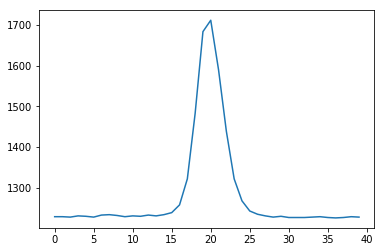

20

In [13]:
sci_im = copy.deepcopy(fits.open(scipath)[0].data)

cent_slc_attempt = gen_cent_slc(sci_im, stdpfit, 20)

plt.plot(np.median(cent_slc_attempt, axis=0))
plt.show()

np.argmax(np.median(cent_slc_attempt, axis=0))

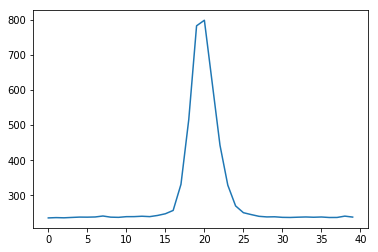

In [48]:
plt.plot(np.median(scislcs, axis=0))

actual_center = np.median(scislcs, axis=0)

In [15]:
stdpmod

array([-4.64332574e-13,  2.65672227e-09, -3.45381551e-06,  1.20520812e-03,
        2.07505869e+02])

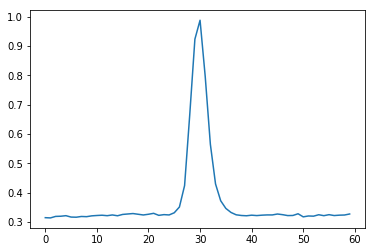

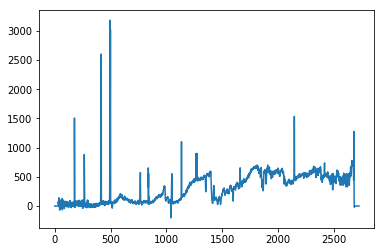

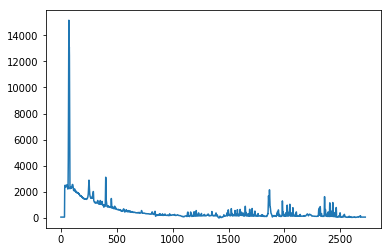

In [13]:
plt.plot(sciprof)
plt.show()

subtr_sci, back_spec = background_subtract(scislcs, sciprof, 0.5)

subtrsciw = weight_function(scislcs)

subtr_sp = extract_spectrum(subtr_sci, subtrsciw)

plt.plot(subtr_sp)
plt.show()

plt.plot(back_spec)
plt.show()

In [5]:
def background_subtract(c_slc, sp_prof, percent_threshold):
        
    cent_slc = copy.deepcopy(c_slc)
    
    #empty lists to hold the background slices and their indices
    background_slices = []
    #background_indices = []
    
    #first pass subtraction

    '''
       deciding which pixels are background
       background pixels are areas where the spatial
       profile is less than the given threshold
    '''
    for i in range(len(cent_slc)):
        
        #setting up empty lists to hold the background pixels and their indices
        background_px = []
        #background_ix = []
        
        #if the pixel value in the slice is less than the threshold, it's background
        for j in range(len(cent_slc[i])):
            if (sp_prof[j] < percent_threshold):
                background_px.append(cent_slc[i][j])
                #background_ix.append(j)
        #appending the pixels and indices from this slice to the list for all slices
        
        #if the list isn't empty, append it, otherwise append zeros
        if background_px != []:
            background_slices.append(background_px)
            #background_indices.append(background_ix)
        else:
            background_slices.append(np.zeros(len(cent_slc[i])))
            #background_indices.append(range(len(cent_slc[i])))
    
    #empty list to hold the background value
    background_vals = []
    
    '''
    #for each slice, find the median of the background
    for i in range(len(background_slices)):
        background_fits.append(np.poly1d(np.polyfit(background_indices[i], background_slices[i], 1)))
    '''
    
    #for each slice, find the median and store it
    for i in range(len(background_slices)):
        background_vals.append(np.median(background_slices[i]))
        
    
    
    '''
    #setting up for iteration
    
    
    bkg_fits = copy.deepcopy( background_fits )
    
    #iterate 10 times
    for n in range(10):
        
        #effectively the same process as above
        bkg_slices = []
        bkg_indices = []
        
        for i in range(len(cent_slc)):
            
            slc_max = np.amax(cent_slc[i])
            bkg_px = []
            bkg_ix = []
            
            #if the pixel value in the slice is less than 10% the difference between the maximum in the slice
            #and the previous background fit, it's also background
            for j in range(len(cent_slc[i])):
                if (np.divide(cent_slc[i][j], slc_max - bkg_fits[i](j)) < 0.1):
                    bkg_px.append(cent_slc[i][j])
                    bkg_ix.append(j)
            if bkg_px != []:
                bkg_slices.append(bkg_px)
                bkg_indices.append(bkg_ix)
                
            else:
                bkg_slices.append(np.zeros(len(cent_slc[i])))
                bkg_indices.append(range(len(cent_slc[i])))
        
        #creating new fits based on the newly selected background
        for i in range(len(bkg_slices)):
            bkg_fits[i] = np.poly1d(np.polyfit(bkg_indices[i], bkg_slices[i], 1))            
        
    '''            
    #the signal is the difference between the centered slices and the background
    signal_slc = copy.deepcopy(cent_slc)
        
    for i in range(len(signal_slc)):
        signal_slc[i] = signal_slc[i] - background_vals[i]
    
    return signal_slc, background_vals


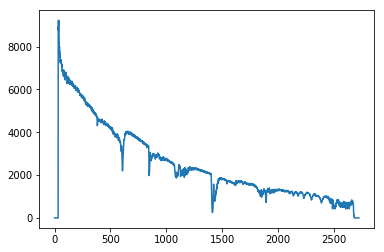

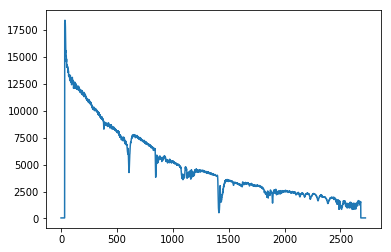

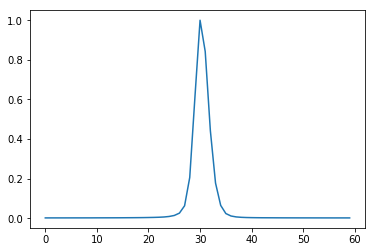

In [9]:
plt.plot(stdspec)
plt.show()

plt.plot(stdvar)
plt.show()

plt.plot(stdprof)
plt.show()

In [39]:
new_mod = copy.deepcopy(stdpmod)

new_mod[4] = new_mod[4] + 100

new_fit = np.poly1d(new_mod)

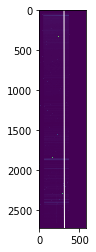

In [40]:
xrange = range(len(sci_im[:,0]))
fig, ax = plt.subplots()
ax.imshow(sci_im)
ax.plot(new_fit(xrange), xrange, color = 'w', linewidth=1)

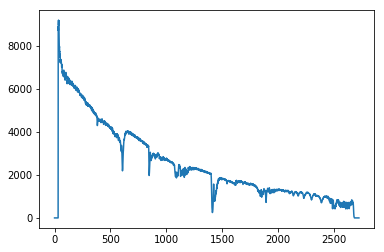

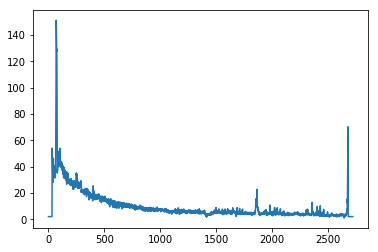

In [11]:
subtr_slcs, back_spec = background_subtract(stdslcs, stdprof, 0.1)

subtrw = weight_function(subtr_slcs)

subtr_spect = extract_spectrum(subtr_slcs, subtrw)

plt.plot(subtr_spect)
plt.show()

plt.plot(back_spec)
plt.show()

In [47]:
    cent_slc = []
    
    for i in range(len(sci_im[:,0])):
        slc = sci_im[i,:]
        
        cent_slc.append(slc[ int(np.around(stdpfit(i) - 10)):int(np.around(stdpfit(i) + 30))])

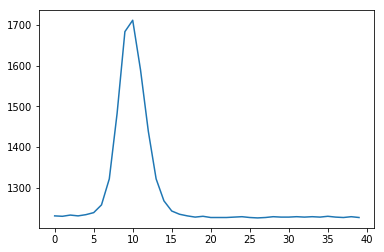

In [48]:
plt.plot(np.median(cent_slc, axis=0))

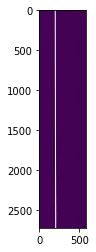

In [66]:
shifted_model = slit_fit_shift(cent_slc, stdpmod, 20)

shifted_poly = np.poly1d(shifted_model)

std_im = copy.deepcopy(fits.open(stdpath)[0].data)

xrange = range(len(std_im[:,0]))
fig, ax = plt.subplots()
ax.imshow(std_im)
ax.plot(shifted_poly(xrange), xrange, color = 'w', linewidth=1)

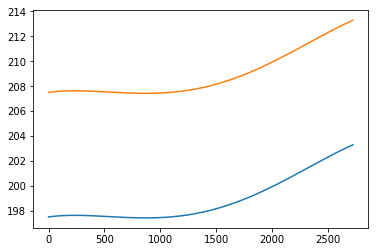

In [67]:
plt.plot(xrange, shifted_poly(xrange))

plt.plot(xrange, stdpfit(xrange))

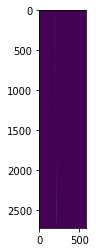

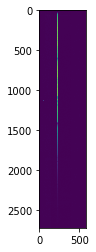

In [24]:
std_im = copy.deepcopy(fits.open(stdpath)[0].data)
shift_im = np.roll(std_im, 20, axis=1)

plt.imshow(std_im)
plt.show()
plt.imshow(shift_im)
plt.show()

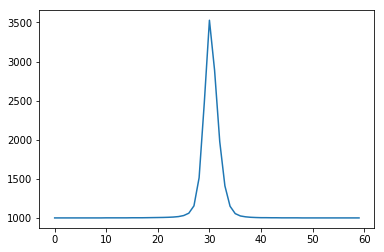

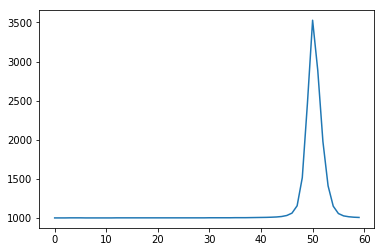

In [27]:
good_slc = gen_cent_slc(std_im, stdpfit, 30)

shift_slc = gen_cent_slc(shift_im, stdpfit, 30)

plt.plot(np.median(good_slc, axis=0))
plt.show()

plt.plot(np.median(shift_slc, axis=0))
plt.show()

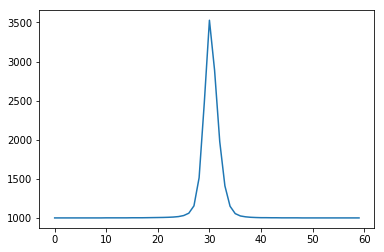

In [32]:
new_mod = slit_fit_shift(shift_slc, stdpmod, 30)
new_fit = np.poly1d(new_mod)

new_slc = gen_cent_slc(shift_im, new_fit, 30)

plt.plot(np.median(new_slc, axis=0))

In [33]:
new_mod

array([-4.64332574e-13,  2.65672227e-09, -3.45381551e-06,  1.20520812e-03,
        2.27505869e+02])